## Setup and Imports

In [1]:
# Standard library imports
import os
import sys
from pathlib import Path
from typing import List

# Environment configuration
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["PYOPENGL_PLATFORM"] = "egl"

# Set rendering backend
if sys.platform == "darwin":
    os.environ["MUJOCO_GL"] = "glfw"
    print("Using macOS with GLFW rendering")
else:
    os.environ["MUJOCO_GL"] = "egl"
    print("Using Linux with EGL rendering")

import warnings

# Suppress pyEDM warnings about no valid prediction indices
warnings.filterwarnings('ignore', message='Simplex: PredictionValid.*')

# Third-party imports
import h5py
import jax
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import mediapy as media
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import mujoco
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal
from scipy import stats
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA

# HuggingFace imports
import huggingface_hub as hf_hub

# Logging configuration
from absl import logging as absl_logging
absl_logging.set_verbosity(absl_logging.ERROR)

# Local/project imports
from track_mjx.agent import checkpointing
from track_mjx.analysis import rollout, render

# Set plot style
plt.style.use('seaborn-v0_8')
colorblind_colors = ['#1f77b4', "#ef7307", '#8E44AD']  # Blue, Orange, Purple

def get_joint_qpos(model, qposes, joint_name):
    """Get qpos value(s) for a specific joint by name."""
    joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, joint_name)
    if joint_id == -1:
        print(f"Joint '{joint_name}' not found!")
        return None

    qpos_addr = model.jnt_qposadr[joint_id]
    joint_type = model.jnt_type[joint_id]

    if joint_type == mujoco.mjtJoint.mjJNT_FREE:
        return qposes[:, qpos_addr : qpos_addr + 7]
    elif joint_type == mujoco.mjtJoint.mjJNT_HINGE:
        return qposes[:, qpos_addr]
    elif joint_type == mujoco.mjtJoint.mjJNT_BALL:
        return qposes[:, qpos_addr : qpos_addr + 4]
    else:
        return qposes[:, qpos_addr]

Using Linux with EGL rendering


## Configuration

In [2]:
# Checkpoint paths
ckpt_path = Path("/root/vast/eric/track-mjx/model_checkpoints/250910_193810_184284/")  # Physics-Aware
joint_ckpt_path = Path("/root/vast/eric/track-mjx/model_checkpoints/250908_134318_569695/")  # Joint Reward Only

# EMG data paths and configuration
MUSCLE_CONFIGS = [
    (5, "Triceps Lateral", "/root/vast/eric/CVAT_mouse_reach/csvs/emg_triceps_fixed_A36-1_2023-07-18_16-54-01_lightOff_tone_on.csv", "Triceps"),
    (8, "Biceps Long", "/root/vast/eric/CVAT_mouse_reach/csvs/emg_biceps_fixed_A36-1_2023-07-18_16-54-01_lightOff_tone_on.csv", "Biceps"),
]

# Trial data CSV
TRIAL_CSV = '/root/vast/eric/CVAT_mouse_reach/csvs/A36-1_2023-07-18_16-54-01_lightOff_tone_on_off_trials_edited.csv'

# Number of trials to analyze
NUM_TRIALS = 46

print(f"Physics-Aware checkpoint: {ckpt_path}")
print(f"  Exists: {ckpt_path.exists()}")
print(f"Joint Reward Only checkpoint: {joint_ckpt_path}")
print(f"  Exists: {joint_ckpt_path.exists()}")

Physics-Aware checkpoint: /root/vast/eric/track-mjx/model_checkpoints/250910_193810_184284
  Exists: True
Joint Reward Only checkpoint: /root/vast/eric/track-mjx/model_checkpoints/250908_134318_569695
  Exists: True


## Download Reference Data

In [3]:
# Download all mouse_arm data files from HuggingFace
data_local_dir = Path.cwd().parent
data_download_dir = hf_hub.snapshot_download(
    repo_id="talmolab/MIMIC-MJX", 
    repo_type="dataset",
    allow_patterns="data/mouse_arm/*.h5",
    local_dir=data_local_dir
)
print(f"Downloaded all mouse_arm data to {data_download_dir}")

# List downloaded files
mouse_arm_dir = Path(data_download_dir) / "data" / "mouse_arm"
h5_files = list(mouse_arm_dir.glob("*.h5"))
print(f"Found {len(h5_files)} H5 files")

Fetching 46 files:   0%|          | 0/46 [00:00<?, ?it/s]

Downloaded all mouse_arm data to /root/vast/eric
Found 46 H5 files


## Load Checkpoint and Configure Environment

In [4]:
# Load the Physics-Aware checkpoint at step 2
ckpt = checkpointing.load_checkpoint_for_eval(ckpt_path, step=2)
cfg = ckpt["cfg"]

# Load the Joint Reward Only checkpoint at step 2
joint_ckpt = checkpointing.load_checkpoint_for_eval(joint_ckpt_path, step=2)
joint_cfg = joint_ckpt["cfg"]

# Update the data path to the downloaded reference data
if h5_files:
    cfg.data_path = ",".join(str(f) for f in sorted(h5_files))
    joint_cfg.data_path = ",".join(str(f) for f in sorted(h5_files))
    print(f"Using {len(h5_files)} data files")
else:
    print("No H5 files found!")


Loading checkpoint from /root/vast/eric/track-mjx/model_checkpoints/250910_193810_184284 at step 2
Loading checkpoint from /root/vast/eric/track-mjx/model_checkpoints/250908_134318_569695 at step 2
Using 46 data files


## Create Environment and Rollout Generator

In [5]:
# Create environment and rollout generator for Physics-Aware model
env = rollout.create_environment(cfg)
inference_fn = checkpointing.load_inference_fn(cfg, ckpt["policy"])
generate_rollout = rollout.create_rollout_generator(
    cfg, 
    env, 
    inference_fn, 
    log_activations=True, 
    log_metrics=True, 
    log_sensor_data=True,
)

# Create environment and rollout generator for Joint Reward Only model
joint_env = rollout.create_environment(joint_cfg)
joint_inference_fn = checkpointing.load_inference_fn(joint_cfg, joint_ckpt["policy"])
joint_generate_rollout = rollout.create_rollout_generator(
    joint_cfg, 
    joint_env, 
    joint_inference_fn, 
    log_activations=True, 
    log_metrics=True, 
    log_sensor_data=True,
)


## Generate Rollout

Generate a single rollout using clip index 20 from the reference data. This will simulate the mouse's reaching behavior based on the trained policy. Feel free to change the clip index to visualize different behaviors in this dataset.

> **Note:** The first time you run this cell, it may take up to 2 minutes to compile the model with JAX, depending on your hardware. Subsequent runs will be much faster.

In [6]:
# generate a single rollout
single_rollout = generate_rollout(clip_idx=20)

## Generate Batch Rollouts

Generate rollouts for all clips in parallel using JAX's vectorized execution.

In [7]:
# Enable JAX compilation cache for faster subsequent runs
persistent_cache = True
if persistent_cache:
    jax.config.update("jax_compilation_cache_dir", "/tmp/jax_cache")
    jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
    jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
    jax.config.update(
        "jax_persistent_cache_enable_xla_caches",
        "xla_gpu_per_fusion_autotune_cache_dir",
    )

# Create JIT-compiled vectorized rollout functions
jit_vmap_generate_rollout = jax.jit(jax.vmap(generate_rollout))
jit_vmap_joint_generate_rollout = jax.jit(jax.vmap(joint_generate_rollout))

# Generate rollouts for all 46 clips
start_idx, end_idx = 0, 46
clip_idxs = np.arange(start_idx, end_idx)

print("Generating Physics-Aware model rollouts...")
batch_rollout = jit_vmap_generate_rollout(clip_idxs)
print(f"  Keys available: {list(batch_rollout.keys())}")
print(f"  Actions shape: {batch_rollout['ctrl'].shape}")
print(f"  Qpos rollout shape: {batch_rollout['qposes_rollout'].shape}")

print("\nGenerating Joint Reward Only model rollouts...")
joint_batch_rollout = jit_vmap_joint_generate_rollout(clip_idxs)
print(f"  Keys available: {list(joint_batch_rollout.keys())}")
print(f"  Actions shape: {joint_batch_rollout['ctrl'].shape}")
print(f"  Qpos rollout shape: {joint_batch_rollout['qposes_rollout'].shape}")


Generating Physics-Aware model rollouts...
  Keys available: ['activations', 'ctrl', 'joint_forces', 'qposes_ref', 'qposes_rollout', 'rollout_metrics', 'sensor_readings', 'state_rewards']
  Actions shape: (46, 119, 9)
  Qpos rollout shape: (46, 120, 4)

Generating Joint Reward Only model rollouts...
  Keys available: ['activations', 'ctrl', 'joint_forces', 'qposes_ref', 'qposes_rollout', 'rollout_metrics', 'sensor_readings', 'state_rewards']
  Actions shape: (46, 119, 9)
  Qpos rollout shape: (46, 120, 4)


## Save Rollout Data to H5 File

Save the batch rollout data in a format compatible with the EMG analysis scripts.

In [8]:
# Save rollout data to H5 files for both models

# 1. Save Physics-Aware model rollouts
output_h5_path_physics = ckpt_path / "rollouts_full_mouse_arm_physics_aware.h5"

with h5py.File(output_h5_path_physics, "w") as f:
    # Save actions (muscle activations) - this is the 'ctrl' field from batch_rollout
    f.create_dataset("actions", data=np.array(batch_rollout["ctrl"]))
    
    # Save qpos data
    f.create_dataset("qposes_rollout", data=np.array(batch_rollout["qposes_rollout"]))
    f.create_dataset("qposes_ref", data=np.array(batch_rollout["qposes_ref"]))
    
    # Save activations if available
    if "activations" in batch_rollout:
        activations_group = f.create_group("activations")
        
        # Save decoder activations
        if "decoder" in batch_rollout["activations"]:
            decoder_group = activations_group.create_group("decoder")
            for key, value in batch_rollout["activations"]["decoder"].items():
                decoder_group.create_dataset(key, data=np.array(value))
        
        # Save intention activations
        if "intention" in batch_rollout["activations"]:
            activations_group.create_dataset("intention", data=np.array(batch_rollout["activations"]["intention"]))

print(f"Saved Physics-Aware rollout data to: {output_h5_path_physics}")
print(f"  Actions shape: {batch_rollout['ctrl'].shape}")

# 2. Save Joint Reward Only model rollouts
output_h5_path_joint = joint_ckpt_path / "rollouts_full_mouse_arm_joint_only.h5"

with h5py.File(output_h5_path_joint, "w") as f:
    # Save actions (muscle activations) - this is the 'ctrl' field from joint_batch_rollout
    f.create_dataset("actions", data=np.array(joint_batch_rollout["ctrl"]))
    
    # Save qpos data
    f.create_dataset("qposes_rollout", data=np.array(joint_batch_rollout["qposes_rollout"]))
    f.create_dataset("qposes_ref", data=np.array(joint_batch_rollout["qposes_ref"]))
    
    # Save activations if available
    if "activations" in joint_batch_rollout:
        activations_group = f.create_group("activations")
        
        # Save decoder activations
        if "decoder" in joint_batch_rollout["activations"]:
            decoder_group = activations_group.create_group("decoder")
            for key, value in joint_batch_rollout["activations"]["decoder"].items():
                decoder_group.create_dataset(key, data=np.array(value))
        
        # Save intention activations
        if "intention" in joint_batch_rollout["activations"]:
            activations_group.create_dataset("intention", data=np.array(joint_batch_rollout["activations"]["intention"]))

print(f"Saved Joint Reward Only rollout data to: {output_h5_path_joint}")
print(f"  Actions shape: {joint_batch_rollout['ctrl'].shape}")

Saved Physics-Aware rollout data to: /root/vast/eric/track-mjx/model_checkpoints/250910_193810_184284/rollouts_full_mouse_arm_physics_aware.h5
  Actions shape: (46, 119, 9)
Saved Joint Reward Only rollout data to: /root/vast/eric/track-mjx/model_checkpoints/250908_134318_569695/rollouts_full_mouse_arm_joint_only.h5
  Actions shape: (46, 119, 9)


## EMG Processing Functions

In [9]:
# Load trial mask
df = pd.read_csv(TRIAL_CSV)

trial_mask = (
    (df['start'].notna()) & 
    (df['end'].notna()) & 
    (df['start'] > 0) & 
    (df['end'] > 0) &
    (df['start'] != df['end'])
)

valid_trials_df = df[trial_mask].copy()
print(f"Valid trials: {len(valid_trials_df)}")

def process_emg_data_individual_trials(emg_file_path, target_samples, num_trials=NUM_TRIALS, duration_ms=250):
    """Process EMG data and return individual trial envelopes"""
    # EMG processing parameters
    fs = 30000
    highpass_cutoff = 20
    lowpass_cutoff = 1000
    envelope_cutoff = 50
    filter_order = 4
    
    # Calculate EMG samples for duration
    emg_duration_samples = int(duration_ms / 1000 * fs)  # Convert ms to samples
    
    # Load EMG data
    emg_data = pd.read_csv(emg_file_path, header=None)
    
    reach_envelopes_processed = []
    
    for i, (idx, row) in enumerate(valid_trials_df.iterrows()):
        if i >= num_trials:
            break
            
        trial_num = idx
        emg_reach_start = int(1/200 * row['start'] * 30000)
        emg_reach_end = emg_reach_start + emg_duration_samples
        
        if trial_num < len(emg_data):
            trial_emg = emg_data.iloc[trial_num, :]
            
            # Process EMG signal
            b, a = signal.butter(filter_order, [highpass_cutoff, lowpass_cutoff], btype='bandpass', fs=fs)
            filtered_emg = signal.filtfilt(b, a, trial_emg)
            
            rectified_emg = np.abs(filtered_emg)
            
            b_env, a_env = signal.butter(filter_order, envelope_cutoff, btype='lowpass', fs=fs)
            emg_envelope = signal.filtfilt(b_env, a_env, rectified_emg)
            
            # Extract envelope during reach period
            if emg_reach_start < len(emg_envelope) and emg_reach_end <= len(emg_envelope):
                reach_envelope = emg_envelope[emg_reach_start:emg_reach_end]
                
                if len(reach_envelope) > 0:
                    # Resample to match target_samples
                    original_time = np.linspace(0, 1, len(reach_envelope))
                    target_time = np.linspace(0, 1, target_samples)
                    resampled_envelope = np.interp(target_time, original_time, reach_envelope)
                    
                    reach_envelopes_processed.append(resampled_envelope)
    
    if not reach_envelopes_processed:
        return None
    
    # Convert to numpy array and normalize
    envelopes_array = np.array(reach_envelopes_processed)
    norm_value = np.percentile(envelopes_array, 98)
    normalized_envelopes = envelopes_array / norm_value
    
    return normalized_envelopes

Valid trials: 46


## Trial-by-Trial EMG vs Simulation Comparison

Compare simulated muscle activations with EMG recordings for individual trials.

In [10]:
# Extract simulation data (first 250ms)
actions = np.clip(batch_rollout["ctrl"], 0.0, 1.0)
n_clips, T, _ = actions.shape

# Only use first 250ms (half the timesteps)
T_half = T // 2
actions = actions[:, :T_half, :]
target_timesteps = 60  # Target 60 timesteps for 250ms at 200 Hz

# Resample to target timesteps if needed
if T_half != target_timesteps:
    print(f"Resampling from {T_half} to {target_timesteps} timesteps")
    original_time = np.linspace(0, 1, T_half)
    target_time = np.linspace(0, 1, target_timesteps)
    
    resampled_actions = np.zeros((n_clips, target_timesteps, actions.shape[2]))
    for clip_idx in range(n_clips):
        for muscle_idx in range(actions.shape[2]):
            f = interp1d(original_time, actions[clip_idx, :, muscle_idx], kind='linear')
            resampled_actions[clip_idx, :, muscle_idx] = f(target_time)
    actions = resampled_actions

time_axis = np.linspace(0, 0.25, target_timesteps)

# Extract Joint Reward Only model data (first 250ms)
print("Processing Joint Reward Only model data...")
joint_actions = np.clip(joint_batch_rollout["ctrl"], 0.0, 1.0)
n_clips_joint, T_joint_full, _ = joint_actions.shape
print(f"Joint Reward Only actions shape: {joint_actions.shape}")

# Only use first 250ms (half the timesteps)
T_joint = T_joint_full // 2
joint_actions = joint_actions[:, :T_joint, :]

# Resample to target timesteps if needed
if T_joint != target_timesteps:
    print(f"Resampling Joint Reward Only from {T_joint} to {target_timesteps} timesteps")
    original_time = np.linspace(0, 1, T_joint)
    target_time = np.linspace(0, 1, target_timesteps)
    
    resampled_joint_actions = np.zeros((n_clips_joint, target_timesteps, joint_actions.shape[2]))
    for clip_idx in range(n_clips_joint):
        for muscle_idx in range(joint_actions.shape[2]):
            f = interp1d(original_time, joint_actions[clip_idx, :, muscle_idx], kind='linear')
            resampled_joint_actions[clip_idx, :, muscle_idx] = f(target_time)
    joint_actions = resampled_joint_actions

# Process EMG data for all muscles
print("Processing EMG data...")
emg_data_by_muscle = {}
for sim_muscle_idx, sim_name, emg_file, muscle_name in MUSCLE_CONFIGS:
    print(f"  Processing {muscle_name}...")
    emg_traces = process_emg_data_individual_trials(emg_file, target_timesteps, NUM_TRIALS, duration_ms=250)
    emg_data_by_muscle[muscle_name] = emg_traces



Resampling from 59 to 60 timesteps
Processing Joint Reward Only model data...
Joint Reward Only actions shape: (46, 119, 9)
Resampling Joint Reward Only from 59 to 60 timesteps
Processing EMG data...
  Processing Triceps...


  Processing Biceps...


Creating plot for Trial 36...


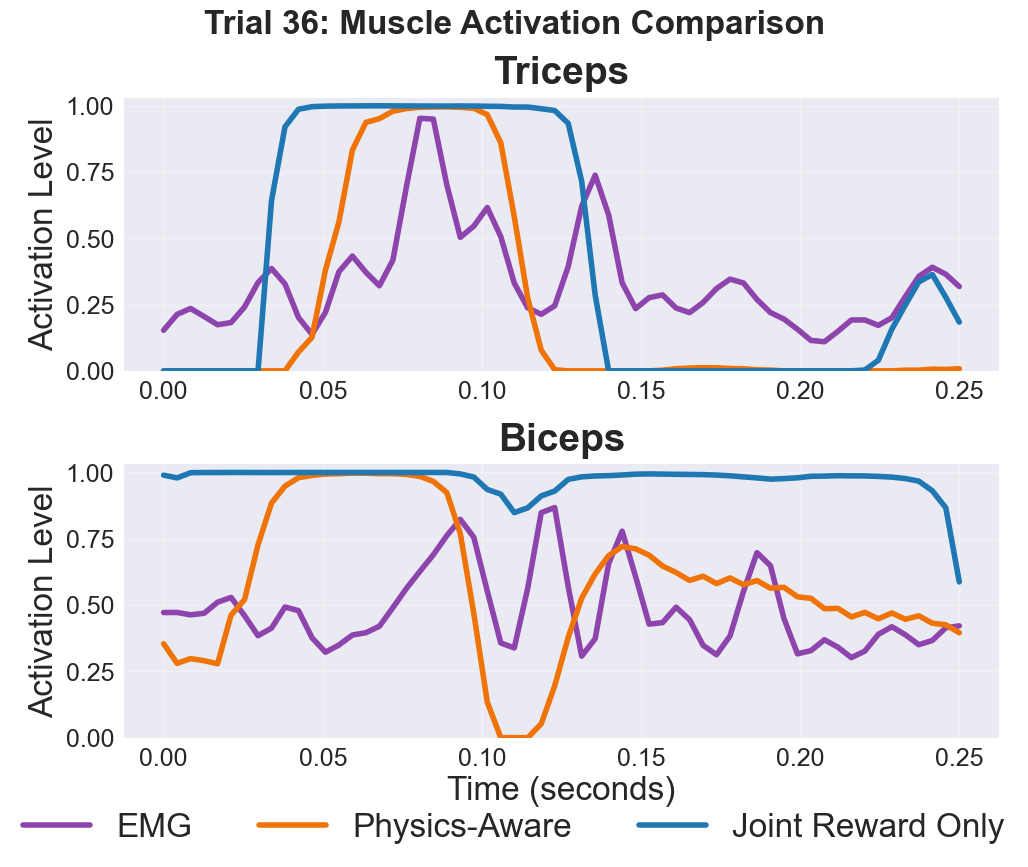

In [11]:
# Plot only clip 20
trial_idx = 35
print(f"Creating plot for Trial {trial_idx + 1}...")

# Create figure (2 rows, 1 column)
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

legend_handles = []
legend_labels = []
legend_created = False

for muscle_idx, (sim_muscle_idx, sim_name, emg_file, muscle_name) in enumerate(MUSCLE_CONFIGS):
    ax = axes[muscle_idx]
    
    # Plot EMG trace for this trial
    emg_traces = emg_data_by_muscle[muscle_name]
    if emg_traces is not None and trial_idx < len(emg_traces):
        line = ax.plot(time_axis, emg_traces[trial_idx], 
                      color=colorblind_colors[2], linewidth=4.0, label='EMG')[0]
        if not legend_created:
            legend_handles.append(line)
            legend_labels.append('EMG')
    
    # Plot Physics-Aware model
    if trial_idx < len(actions):
        physics_trace = actions[trial_idx, :, sim_muscle_idx]
        line = ax.plot(time_axis, physics_trace, 
                      color=colorblind_colors[1], linewidth=4.0,
                      label='Physics-Aware')[0]
        if not legend_created:
            legend_handles.append(line)
            legend_labels.append('Physics-Aware')
    
    # Plot Joint Reward Only model
    if trial_idx < len(joint_actions):
        joint_trace = joint_actions[trial_idx, :, sim_muscle_idx]
        line = ax.plot(time_axis, joint_trace, 
                      color=colorblind_colors[0], linewidth=4.0,
                      label='Joint Reward Only')[0]
        if not legend_created:
            legend_handles.append(line)
            legend_labels.append('Joint Reward Only')
    
    legend_created = True
    
    # Customize subplot
    ax.set_title(f'{muscle_name}', fontsize=28, fontweight='bold', pad=10)
    ax.set_ylabel('Activation Level', fontsize=24)
    if muscle_idx == len(MUSCLE_CONFIGS) - 1:
        ax.set_xlabel('Time (seconds)', fontsize=24)
    ax.set_ylim(0, 1.03)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=18)

# Add legend
fig.legend(legend_handles, legend_labels, 
          loc='lower center', fontsize=24, 
          bbox_to_anchor=(0.5, -0.05), ncol=3, framealpha=0.9)

# Add overall title
fig.suptitle(f'Trial {trial_idx + 1}: Muscle Activation Comparison', 
            fontsize=24, fontweight='bold', y=1.03)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.12, top=0.92)

# Save figure
plt.savefig(ckpt_path / f"trial_{trial_idx + 1}_muscle_comparison.pdf", bbox_inches='tight')
plt.show()

## Average Muscle Activation Across All Clips

Plot the average muscle activation across all clips with standard error shading.

Computing averaged muscle activations across all clips...


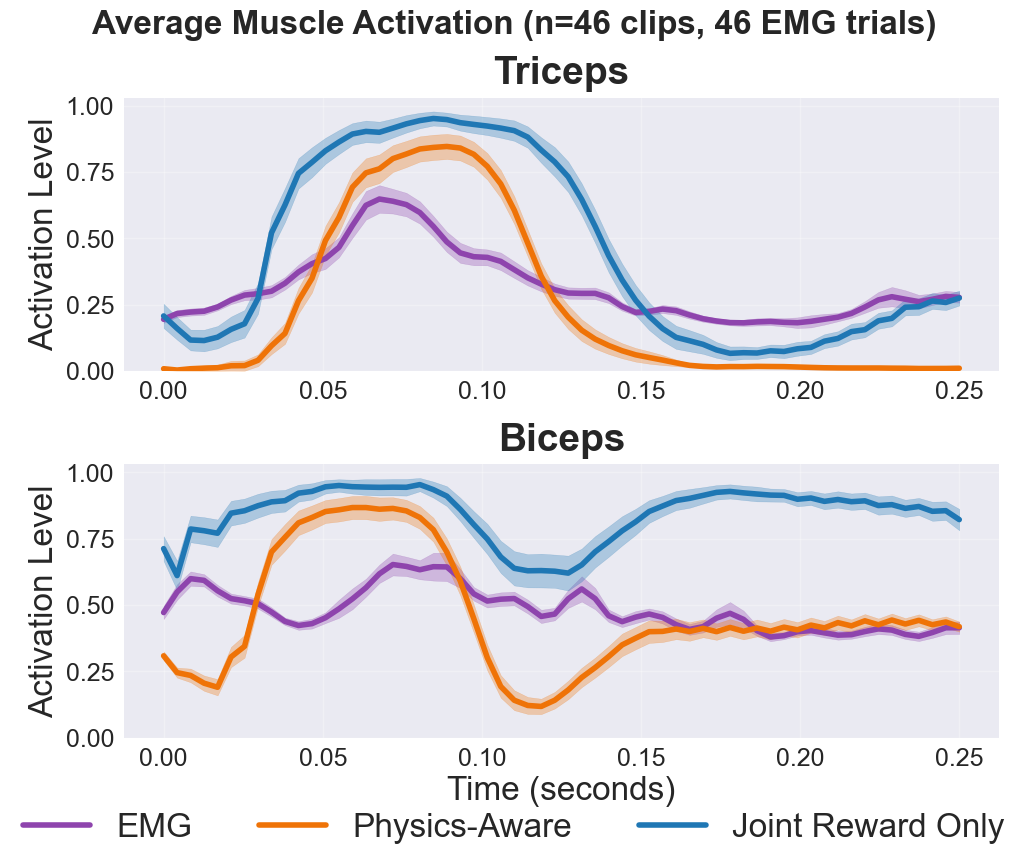

Averaged across 46 simulation clips and 46 EMG trials


In [12]:
# Calculate averages and standard errors across all clips
print("Computing averaged muscle activations across all clips...")

# Create single averaged plot
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

legend_handles = []
legend_labels = []
legend_created = False

for muscle_idx, (sim_muscle_idx, sim_name, emg_file, muscle_name) in enumerate(MUSCLE_CONFIGS):
    ax = axes[muscle_idx]
    
    # Process EMG data - average across trials
    emg_traces = emg_data_by_muscle[muscle_name]
    if emg_traces is not None and len(emg_traces) > 0:
        emg_mean = np.mean(emg_traces, axis=0)
        emg_sem = np.std(emg_traces, axis=0) / np.sqrt(len(emg_traces))
        
        # Plot EMG with shaded error region (FIXED: match shaded color to line color)
        line = ax.plot(time_axis, emg_mean, 
                      color=colorblind_colors[2], linewidth=4.0, label='EMG')[0]
        ax.fill_between(time_axis, emg_mean - emg_sem, emg_mean + emg_sem,
                        color=colorblind_colors[2], alpha=0.3)  # Changed to match line
        if not legend_created:
            legend_handles.append(line)
            legend_labels.append('EMG')
    
    # Process Physics-Aware model - average across clips
    physics_mean = np.mean(actions[:, :, sim_muscle_idx], axis=0)
    physics_sem = np.std(actions[:, :, sim_muscle_idx], axis=0) / np.sqrt(len(actions))
    
    line = ax.plot(time_axis, physics_mean,
                  color=colorblind_colors[1], linewidth=4.0, label='Physics-Aware')[0]
    ax.fill_between(time_axis, physics_mean - physics_sem, physics_mean + physics_sem,
                    color=colorblind_colors[1], alpha=0.3)  # Changed to match line
    if not legend_created:
        legend_handles.append(line)
        legend_labels.append('Physics-Aware')
    
    # Process Joint Reward Only model - average across clips
    joint_mean = np.mean(joint_actions[:, :, sim_muscle_idx], axis=0)
    joint_sem = np.std(joint_actions[:, :, sim_muscle_idx], axis=0) / np.sqrt(len(joint_actions))
    
    line = ax.plot(time_axis, joint_mean,
                  color=colorblind_colors[0], linewidth=4.0, label='Joint Reward Only')[0]
    ax.fill_between(time_axis, joint_mean - joint_sem, joint_mean + joint_sem,
                    color=colorblind_colors[0], alpha=0.3)  # Changed to match line
    if not legend_created:
        legend_handles.append(line)
        legend_labels.append('Joint Reward Only')
    
    legend_created = True
    
    # Customize subplot
    ax.set_title(f'{muscle_name}', fontsize=28, fontweight='bold', pad=10)
    ax.set_ylabel('Activation Level', fontsize=24)
    if muscle_idx == len(MUSCLE_CONFIGS) - 1:
        ax.set_xlabel('Time (seconds)', fontsize=24)
    ax.set_ylim(0, 1.03)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=18)

# Add legend
fig.legend(legend_handles, legend_labels, 
          loc='lower center', fontsize=24, 
          bbox_to_anchor=(0.5, -0.05), ncol=3, framealpha=0.9)

# Add overall title
n_trials_emg = len(emg_traces) if emg_traces is not None else 0
fig.suptitle(f'Average Muscle Activation (n={n_clips} clips, {n_trials_emg} EMG trials)', 
            fontsize=24, fontweight='bold', y=1.03)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.12, top=0.92)

# Save figure
plt.savefig(ckpt_path / "average_muscle_comparison.pdf", bbox_inches='tight')
plt.show()

print(f"Averaged across {n_clips} simulation clips and {n_trials_emg} EMG trials")


EMG ERROR ANALYSIS
Physics-Aware model: 46 clips, 119 timesteps
Joint Reward Only model: (46, 119, 9)

Processing EMG data for error analysis...
  Processing Triceps...
  Processing Biceps...

Calculating errors for Physics-Aware...
  Triceps: Processed 46 clips
  Biceps: Processed 46 clips

Calculating errors for Joint Reward Only...
  Triceps: Processed 46 clips
  Biceps: Processed 46 clips


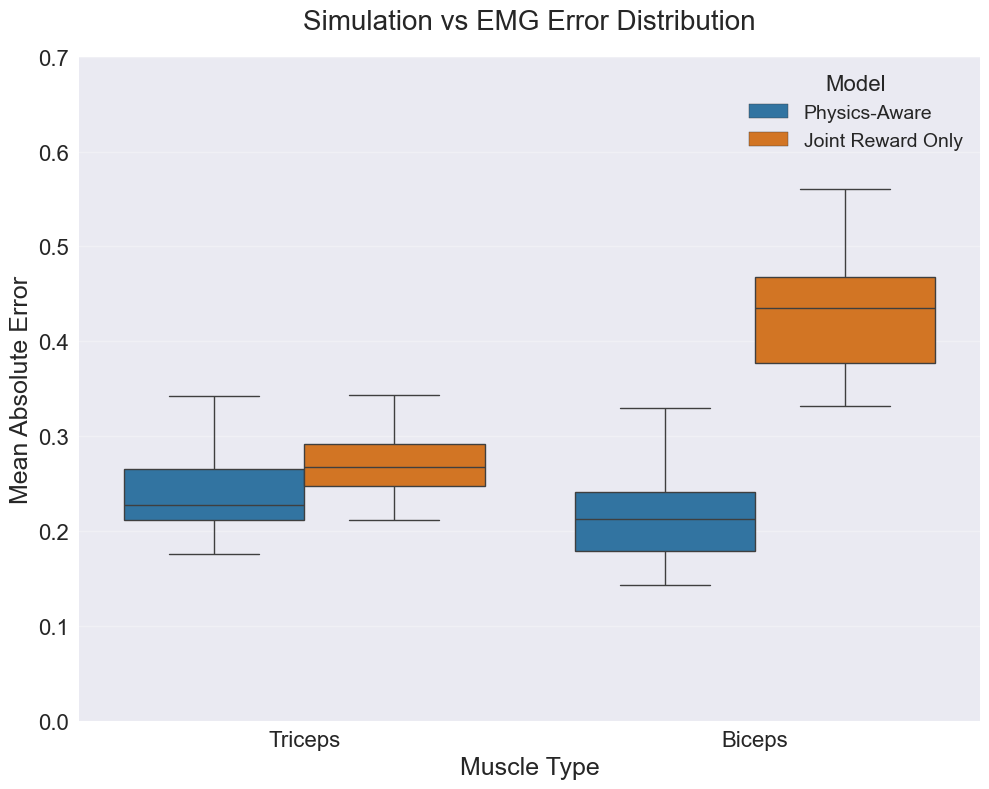


ERROR ANALYSIS SUMMARY

Physics-Aware:
--------------------------------------------------

  Triceps:
    Mean:    0.2405
    Median:  0.2276
    Std:     0.0442
    Q1:      0.2120
    Q3:      0.2652

  Biceps:
    Mean:    0.2255
    Median:  0.2132
    Std:     0.0698
    Q1:      0.1790
    Q3:      0.2414

Joint Reward Only:
--------------------------------------------------

  Triceps:
    Mean:    0.2783
    Median:  0.2678
    Std:     0.0501
    Q1:      0.2480
    Q3:      0.2918

  Biceps:
    Mean:    0.4282
    Median:  0.4352
    Std:     0.0557
    Q1:      0.3768
    Q3:      0.4674

COMPARISON:
--------------------------------------------------

Triceps:
  Joint Reward Only Mean Error:  0.2783
  Physics-Aware Mean Error:      0.2405
  Improvement:                   0.0378
  Percent Change:                13.58%

Biceps:
  Joint Reward Only Mean Error:  0.4282
  Physics-Aware Mean Error:      0.2255
  Improvement:                   0.2027
  Percent Change:            

In [13]:
# --------------------------- EMG ERROR ANALYSIS -----------------------------------
print("\n" + "="*80)
print("EMG ERROR ANALYSIS")
print("="*80)

# Use full 500ms duration for error analysis
actions_full = np.clip(batch_rollout["ctrl"], 0.0, 1.0)
n_clips_full, T_full, _ = actions_full.shape
target_samples_full = T_full  # Use full simulation timesteps (100 for 500ms)

print(f"Physics-Aware model: {n_clips_full} clips, {T_full} timesteps")

# Extract Joint Reward Only model data (full duration)
joint_actions_full = np.clip(joint_batch_rollout["ctrl"], 0.0, 1.0)
print(f"Joint Reward Only model: {joint_actions_full.shape}")

# Process EMG data for full duration (500ms)
print("\nProcessing EMG data for error analysis...")
emg_data_full = {}
for sim_muscle_idx, sim_name, emg_file, muscle_name in MUSCLE_CONFIGS:
    print(f"  Processing {muscle_name}...")
    emg_traces = process_emg_data_individual_trials(emg_file, target_samples_full, 
                                                     num_trials=n_clips_full, 
                                                     duration_ms=500)
    emg_data_full[muscle_name] = emg_traces

# Calculate errors for both models
all_errors_data = []

for condition_name, actions_data in [("Physics-Aware", actions_full), 
                                     ("Joint Reward Only", joint_actions_full)]:
    print(f"\nCalculating errors for {condition_name}...")
    
    for muscle_idx, sim_name, emg_file, muscle_name in MUSCLE_CONFIGS:
        emg_traces = emg_data_full[muscle_name]
        
        if emg_traces is not None:
            # Get simulation traces for this muscle
            sim_traces = actions_data[:, :, muscle_idx]
            
            # Match number of clips between sim and EMG
            n_clips_to_use = min(len(sim_traces), len(emg_traces))
            
            # Calculate error for each clip
            for clip_idx in range(n_clips_to_use):
                sim_trace = sim_traces[clip_idx, :]
                emg_trace = emg_traces[clip_idx, :]
                
                # Ensure same length
                min_len = min(len(sim_trace), len(emg_trace))
                sim_trace = sim_trace[:min_len]
                emg_trace = emg_trace[:min_len]
                
                # Calculate mean absolute error
                clip_error = np.mean(np.abs(sim_trace - emg_trace))
                
                all_errors_data.append({
                    'Condition': condition_name,
                    'Muscle': muscle_name,
                    'Error': clip_error,
                    'Clip': clip_idx
                })
            
            print(f"  {muscle_name}: Processed {n_clips_to_use} clips")

# Create DataFrame
df_errors = pd.DataFrame(all_errors_data)

# Create grouped box and whisker plot
fig, ax = plt.subplots(figsize=(10, 8))

# Create grouped box plot
box_plot = sns.boxplot(data=df_errors, x='Muscle', y='Error', hue='Condition',
                      palette=['#1f77b4', "#ef7307"],  # Blue for Physics-Aware, Orange for Joint Reward Only
                      ax=ax, showfliers=False)

# Customize the plot
ax.set_xlabel('Muscle Type', fontsize=18)
ax.set_ylabel('Mean Absolute Error', fontsize=18)
ax.set_title('Simulation vs EMG Error Distribution', fontsize=20, pad=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylim(0, 0.7)

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Model', title_fontsize=16, fontsize=14, loc='upper right')

# Add grid
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(ckpt_path / "emg_error_boxplot.pdf", bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("ERROR ANALYSIS SUMMARY")
print("="*80)

for condition in df_errors['Condition'].unique():
    print(f"\n{condition}:")
    print("-" * 50)
    
    condition_data = df_errors[df_errors['Condition'] == condition]
    
    for muscle in condition_data['Muscle'].unique():
        muscle_data = condition_data[condition_data['Muscle'] == muscle]['Error']
        print(f"\n  {muscle}:")
        print(f"    Mean:    {muscle_data.mean():.4f}")
        print(f"    Median:  {muscle_data.median():.4f}")
        print(f"    Std:     {muscle_data.std():.4f}")
        print(f"    Q1:      {muscle_data.quantile(0.25):.4f}")
        print(f"    Q3:      {muscle_data.quantile(0.75):.4f}")

# Comparison analysis
print(f"\n{'COMPARISON:'}")
print("-" * 50)

for muscle in df_errors['Muscle'].unique():
    print(f"\n{muscle}:")
    
    physics_aware = df_errors[(df_errors['Condition'] == 'Physics-Aware') & 
                              (df_errors['Muscle'] == muscle)]['Error']
    joint_only = df_errors[(df_errors['Condition'] == 'Joint Reward Only') & 
                           (df_errors['Muscle'] == muscle)]['Error']
    
    if len(physics_aware) > 0 and len(joint_only) > 0:
        improvement = joint_only.mean() - physics_aware.mean()
        percent_change = (improvement / joint_only.mean()) * 100
        
        print(f"  Joint Reward Only Mean Error:  {joint_only.mean():.4f}")
        print(f"  Physics-Aware Mean Error:      {physics_aware.mean():.4f}")
        print(f"  Improvement:                   {improvement:.4f}")
        print(f"  Percent Change:                {percent_change:.2f}%")

print("="*80)